# Codeword Detection Development Dataset Generation

Done by Linan Qiu [(github.com/linanqiu)](https://github.com/linanqiu) for TextIQ

In this notebook, we generate a development / test dataset for the codeword detection problem.

The codeword detection problem can be framed as the following: 

- A codeword is a word that is used in a different context from its usual context. (eg. using `cheeseburger` to denote `equities` in an email between equities traders)
- Given a corpus containing codewords (**codeword corpus**) and a reference corpus not containing codewords (**reference corpus**), find codewords in the codeword corpus.

As far as the author knows, no dataset specifically containing a known list of codewords exist. Hence, a synthetic dataset is needed to facilitate experiments for this problem.

## Approach Overview

To generate a synthetic codeword corpus, we do the following steps

1. Get a reference corpus containing little to no codewords
2. Select $|\mathbf{x}|$ words as codewords. Denote this set as $\mathbf{x}$ where each $x_i$ is a codeword
3. Generate a set $\mathbf{y}$ where each $y_i = x_j | j \neq i$ ie. each word in $\mathbf{y}$ maps to a random word in $\mathbf{x}$ that is not the same as itself
4. Generate a codeword corpus by replacing every $x_i$ in reference corpus with $y_i$ (which will not be the same as $x_i$)

Then, to verify a detection method's validity, we can

1. Provide the detector both corpuses (codeword and reference)
2. Make detector find codewords in codeword corpus
3. Compare against $\mathbf{y}$ for retrieval rate

However, this still leaves some questions open, including what reference corpus to choose, how adequate words can be chosen as codeword candidates, and how a baseline for codeword detection can be made. This will be addressed along the way.

First we get some hygiene `python` stuff out of the way and make our graphs pretty.

In [12]:
%matplotlib inline

import cPickle as pickle
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Synthetic Codeword Corpus Creation

### Reference Corpus Choice

We choose the WSJ Corpus from the PennTreebank to be the reference corpus due to the similarity in the content of the text and the data of potential TextIQ clients.

A helper function is made in `lib.corpus_parser` to use `nltk` to parse the WSJ corpus. Tip to future replications: use a symlink to link `LDC99T42-Treebank-3/package/treebank_3/parsed/mrg/wsj` and `LDC99T42-Treebank-3/package/treebank_3/parsed/mrg/brown` to `~/nltk_data/corpora/ptb/wsj` and `~/nltk_data/corpora/ptb/brown` so that `nltk` can parse the WSJ corpus directly.

In [2]:
# reads wsj corpus and saves all lines to all-lines.pkl
from lib.corpus_parser import *

all_lines = parse_wsj()
pickle.dump(all_lines, open('all-lines.pkl', 'wb'))

### Codeword Selection

We need a way to select $|\mathbf{x}|$ codewords (in this case, $|\mathbf{x}| = 100$ an arbitrary number base on intuition about the size of the corpus and usage patterns.)

#### TF-IDF

A naive way to do this would be TF-IDF as was initially used where

- $T_{x_i}$ is the number of times word $x_i$ appeared in the entire corpus
- $D_{x_i}$ is the number of documents $x_i$ appeared in the entire corpus
- $N_D$ is the number of documents in the entire corpus ie.
- $\mathrm{Rank}_{x_i} = \mathrm{TFIDF}_{x_i} = \left(\log{(T_{x_i}} + 1\right) * \left(\log{(1 + N_D / D_{x_i})} \right)$ where the left term is the term frequency smoothed such that 0s won't occur, and the right term is the inverse document frequency.

We select the top $|\mathbf{x}|$ words. The intuition behind this method was to downweight terms that appeared in every document (such as "the", "a", "he"), and upweight rarer terms.

However, this method was disappointing since it upweighted rare terms too much. In particular, note that the inverse document frequency portion of $\mathrm{TFIDF}$ is a decreasing function. That means words appearing only 1 time is upweighted the most. Hence, a lot of names and esoteric words that only occur once were selected. The top words consisted of "yeargin", "steinhardt", "corry", "psyllium". We needed an alternative method that downweighted very frequent words, upweighted rarer words, but also **downweighted extremely rare words**.

#### Gamma Distribution

A good way to do this was to use a Gamma distribution instead of the inverse document frequency measure. That means

$\mathrm{Rank}_{x_i} = \left(\log{(T_{x_i}} + 1\right) * \left(g(D_{x_i})\right)$ where $g(y)$ is the Gamma distribution function fitted on a given $\alpha$ and $\beta$. Specifically, we can set $\alpha$ and $\beta$ such that the mode of the distribution is a certain proportion of documents (ie. this is the proportion of documents that "important words" should belong in) and the mean to be 2 times of that. Choosing $\mathrm{Mode} = 0.075 * N_D = (\alpha-1)*\beta$ and hence $\mathrm{Mean} = 0.15 * D = \alpha * \beta$, we make the assumption that important words should be present in around 7.5% to 15% of articles.

This Gamma distribution could would like this:

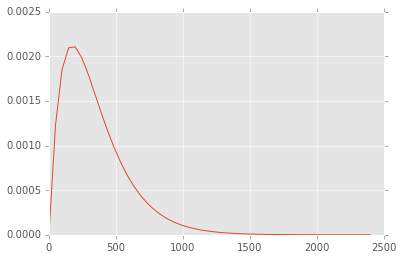

In [13]:
d = len(all_lines)
beta = 0.075 * d
alpha = 0.15 * d / beta
loc = 0

from scipy.stats import gamma
import numpy as np

rv = gamma(a=alpha, loc=loc, scale=beta)
x = np.linspace(0, 2400)
plt.plot(x, rv.pdf(x))
plt.show()

This function upweights words that appear not so frequently, but downweights words that appear very rarely (along with words that appear frequently). The results turned out to be very reasonable for the WSJ corpus. Top words include "bonds", "index", "japanese", "oil", "traders".

This result should not be surprising given that TF-IDF is a measure meant for weighting words in a single document among many documents, not an aggregate measure across documents.

This allows us to select $\mathbf{x}$ by taking the top $|\mathbf{x}| = 100$ words using $\mathbf{\mathrm{Rank}}$.

### Generate Substitution Key

Now that we have $\mathbf{x}$ we want to generate a set $\mathbf{y}$ permuted version of $\mathbf{x}$ such that $y_i = x_j | j \neq i$ ie. each word in $\mathbf{y}$ maps to a random word in $\mathbf{x}$ that is not the same as itself. This is rather trivial, and we save the key in a pickle and a `.json` so that we can read it easily. We also present the substituted dictionary in the output below.

In [3]:
from lib.substitute import *

substitute_key = generate_substitute_key(all_lines)
pickle.dump(substitute_key, open('substitute-key.pkl', 'wb'))
import simplejson
f = open('substitute-key.json', 'wb')
simplejson.dump(substitute_key, f)
f.close()

print(substitute_key)

{u'agency': u'buying', u'office': u'issue', u'show': u'foreign', u'september': u'point', u'dollar': u'august', u'trade': u'city', u'london': u'oil', u'committee': u'third-quarter', u'japan': u'demand', u'issues': u'index', u'cut': u'decline', u'system': u'selling', u'analyst': u'office', u'bush': u'debt', u'program': u'congress', u'systems': u'funds', u'treasury': u'program', u'policy': u'house', u'8': u'bid', u'bonds': u'country', u'bid': u'nov.', u'him': u'economy', u'association': u'system', u'notes': u'committee', u'drop': u'insurance', u'she': u'news', u'house': u'him', u'japanese': u'life', u'computer': u'issues', u'home': u'japan', u'insurance': u'jones', u'index': u'credit', u'congress': u'tax', u'chicago': u'she', u'research': u'cut', u'state': u'british', u'firms': u'production', u'issue': u'computer', u'august': u'assets', u'power': u'growth', u'decline': u'department', u'friday': u'power', u'takeover': u'california', u'california': u'drop', u'news': u'loans', u'debt': u'dol

### Codeword Corpus Generation

Now we can generate a codeword corpus by going through the reference corpus and replacing every occurence of word $x_i$ with $y_i$. We retain the original reference corpus and save both in pickles.

In [4]:
all_lines_substituted = generate_substitute_corpus(all_lines, substitute_key)
pickle.dump(all_lines_substituted, open('corpus-substituted.pkl', 'wb'))
pickle.dump(all_lines, open('corpus-original.pkl', 'wb'))

## Verification of Baseline Codeword Detection

### Generate Embeddings

Now we run both corpuses over `word2vec`. The code below by default reads in the models from storage. This is because I usually run the training on a computer other than my own, and usually on two different computers. However, if you decide to torture your computer, feel free to take around 12 hours on this step (based on the default parameters in `w2v.w2v`). The default parameters used are `model = gensim.models.Word2Vec(sentences, min_count=5, workers=8, iter=300, window=15, size=300, negative=25)` as recommended by Jasneet.

In [5]:
from w2v.w2v import *

# all_lines_original = build_sentences(all_lines_original_filename)
# all_lines_substituted = build_sentences(all_lines_substituted_filename)
#
# original_model = model_from_sentences(all_lines_original)
# substituted_model = model_from_sentences(all_lines_substituted)
#
# original_model.save_word2vec_format('./models/corpus-original-w2v.mdl', binary=True)
# substituted_model.save_word2vec_format('./models/corpus-substituted-w2v.mdl', binary=True)

original_model = model_from_saved("./models/corpus-original-w2v.mdl", binary=True)
substituted_model = model_from_saved("./models/corpus-substituted-w2v.mdl", binary=True)

### Finding Common Words

Then we find the common words in both corpuses. Since we are using a synthetic dataset, and there is always a one to one matching between $\mathbf{x}$ and $\mathbf{y}$, the two corpuses should contain the same vocabularies. However, this won't always be the case in actual situations.

In [6]:
from comparison.similarity import *
intersect_vocab = set(substituted_model.vocab).intersection(set(original_model.vocab))

### Detecting Codewords

We detect codewords by measuring, from the two corpuses, what a word is similar to. 

- For each word $w_i$, we find $\mathbf{z}_{w_i, x, n}$, the top $n$ words that are similar to $w_i$ as predicted by `word2vec` in gensim's `most_similar` method using the **reference corpus**
- For that same word $w_i$ we find $\mathbf{z}_{w_i, y, n}$ the top $n$ words that are similar to $w_i$ as predicted by the same method but using the **codeword corpus**
- We find $\mathbf{S}$, the intersection of $\mathbf{z}_{w_i, x, n}$ and $\mathbf{z}_{w_i, y, n}$. In other words, every word in $S_i \in \mathbf{S}$ is defined by $S_i \in \{\mathbf{z}_{w_i, x, n} \cap \mathbf{z}_{w_i, y, n}\}$.
- We record the length of the intersection, $|\mathbf{S}|$, for each word $w_i$.

In [7]:
vocabs = generate_similarity_counts(original_model, substituted_model, intersect_vocab)
pickle.dump(vocabs, open('vocabs-compared.pkl', 'wb'))

Intuition tells us that codewords are used differently in the codeword corpus than in the reference corpus. In that case $|\mathbf{S}|$ should be small for codewords and large for non-codewords. Non-codewords are used similarly in both reference corpus and codeword corpus, while codewords are used differently in both corpuses. We can use this to detect codewords.

## Results

We find that we were able to isolate words that have few similarity intersection counts. The distribution of similarity intersection counts across all words look normal with the exception of a cluster of codewords at the left tail. 

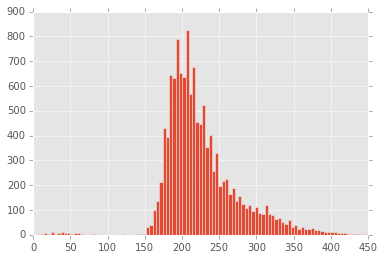

In [15]:
# plot results
codewords = sorted(vocabs, key=vocabs.get)
positive = 0
false_positive = 0
count = 1
results = {}

for word in codewords:
    if word in substitute_key:
        positive += 1
    else:
        false_positive += 1
    results[count] = {'count': count, 'positive': positive, 'false_positive': false_positive, 'false_negative': len(substitute_key) - positive}
    count += 1

import pandas as pd
import matplotlib
import matplotlib.pyplot as plot
matplotlib.style.use('ggplot')

# distribution of comparison counts
plot.hist(vocabs.values(), bins=100)
plot.show()

We can check that the cluster of words at the left tail are indeed codewords. We first sort the all words by similarity count in ascending order. The words with fewest similarity counts will be at the front.

Then, we iterate through the words and record (for every count)

- `positive`: number of actual codewords correctly identified
- `false_positive`: number of words wrongly classified as codeword
- `false_negative`: number of actual codewords that were not detected

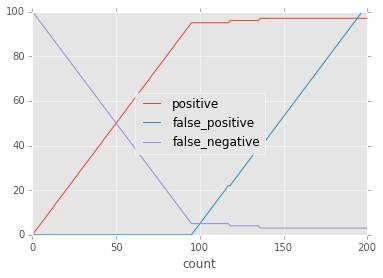

In [16]:
# plot results
dataframe = pd.DataFrame.from_dict(results, orient='index')
dataframe.plot(x='count', y=['positive', 'false_positive', 'false_negative'], xlim=[0, 200], ylim=[0, 100])
plot.show()

As we increase the counts. We find that at a count of around 100, we have a very high positive rate with a very low false positive and false negative rate. Even lower false positive rates can be achieved by sacrifising some false negative rates.

In [19]:
threshold = 100
positive = 0
false_positive = 0
count = 1

for word in codewords:
    if word in substitute_key:
        positive += 1
    else:
        false_positive += 1
    count += 1
    
    if count > 100:
        break

print('positive: %d\nfalse positive: %d\nfalse negative: %d' % (positive, false_positive, len(substitute_key) - positive))

positive: 95
false positive: 5
false negative: 5
